# Deliverable 3


## Section 1: Full Pipeline Construction (Preprocessing + Model)


In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

import time

# Custom class so that we can use it in the pipeline
class Outlier_Capper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_cap_indices):
        self.cols_to_cap_indices = cols_to_cap_indices
        self.upper_fences = {}

    def fit(self, X, y=None):
        for col_idx in self.cols_to_cap_indices:
            column_data = X[:, col_idx]
            Q1 = np.percentile(column_data, 25)
            Q3 = np.percentile(column_data, 75)
            IQR = Q3 - Q1
            self.upper_fences[col_idx] = Q3 + 1.5 * IQR
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col_idx, fence in self.upper_fences.items():
            X_copy[:, col_idx] = np.where(X_copy[:, col_idx] > fence, fence, X_copy[:, col_idx])
        return X_copy

# Load and clean dataset
data = pd.read_csv("./datasets/cs-training.csv")
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# Combine similar columns to avoid multicollinearity as discovered in deliverable 2
data['Total_Times_Past_Due'] = (
    data['NumberOfTime30-59DaysPastDueNotWorse'] +
    data['NumberOfTime60-89DaysPastDueNotWorse'] +
    data['NumberOfTimes90DaysLate']
)
data = data.drop(columns=[
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
])

X = data.drop(columns=["SeriousDlqin2yrs"])
y = data["SeriousDlqin2yrs"]


# Pipelines

outlier_indices_to_cap = [0, 2, 3] # RevolvingUtilization, DebtRatio, MonthlyIncome 
log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('capper', Outlier_Capper(cols_to_cap_indices=outlier_indices_to_cap)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('capper', Outlier_Capper(cols_to_cap_indices=outlier_indices_to_cap)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight='balanced'))
])


# Comparison metrics 
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Model Comparison: \n")
print("Logistic Regression Results:")

lr_start_time = time.perf_counter()

log_cv_results = cross_validate(
    log_pipeline, 
    X.to_numpy(), 
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

lr_end_time = time.perf_counter()
elapsed_lr_time = lr_end_time - lr_start_time

for metric in scoring.keys():
    mean = np.mean(log_cv_results[f'test_{metric}'])
    std = np.std(log_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")

print(f"Time to run Logistic Regression Cross-Validation: {elapsed_lr_time:.4f} seconds")


print("Random Forest Results:")

rf_start_time = time.perf_counter()

rf_cv_results = cross_validate(
    rf_pipeline, 
    X.to_numpy(), 
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

rf_end_time = time.perf_counter()
elapsed_rf_time = rf_end_time - rf_start_time

# Print results
for metric in scoring.keys():
    mean = np.mean(rf_cv_results[f'test_{metric}'])
    std = np.std(rf_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")
print(f"Time to run Random Forest Cross-Validation: {elapsed_rf_time:.4f} seconds")
print(f"Number of Random Forest Nodes: {rf_pipeline._final_estimator.n_estimators}")


Model Comparison: 

Logistic Regression Results:
  recall  : 0.738 ± 0.012
  f1      : 0.295 ± 0.005
  roc_auc : 0.831 ± 0.005
Time to run Logistic Regression Cross-Validation: 1.3092 seconds
Random Forest Results:
  recall  : 0.148 ± 0.007
  f1      : 0.231 ± 0.009
  roc_auc : 0.838 ± 0.003
Time to run Random Forest Cross-Validation: 159.5962 seconds
Number of Random Forest Nodes: 200


## Analysis of Results

**Recall:**
The logistic regression model boasts a far higher recall score of 0.738 versus the random forest model's 0.148. This means that the logistic regression model would be able to more successfully predict if someone will experience financial distress in the next two years. This is a very important metric to the bank. If they give loans to people who won't be able to pay them back they risk great financial loss.

**F1-Score:**
The F1-scores for both models are similar but the logistic regression model pulls ahead slightly at 0.295 versus random forest model's 0.229. This means the logistic regression model achieves a better balance between precision and recall compared to the random forest model.

**ROC AUC:**
The random forest model is superior in this metric with a score of 0.838 versus the logistic regression model's 0.831. This means the random forest model is better at discriminating between people who are risky to loan to and people who are not. This is probably because the random forest model is more conservative when classifying risky people to loan to as seen by its low recall score. However, given the difference is so small it is not very significant.

**Time spent to run cross-validation, and number of Random Forest estimators:**
We can see that there is a large discrepancy amongst the time spent to run both these models. The performance while training with Logistic Regression is far greater than that of Random Forest's, with Logistic Regression taking only ~1.2 seconds versus ~161.5 seconds for Random Forest; a nearly 135x difference in performance. Not only that, but Random Forest creates 200 estimators in order to create the appropriate model, which is extremely large and nonsensical for the given task.

Based on these results the logistic regression model seems like a clear winner due to its superiority in Recall and F1-Score as well as its comparable ROC AUC score.


### Design Choice Justification

We decided to just use a pipeline and not a column transformer as it is not necessary for our dataset. This is because we only have numerical columns,  just using the pipeline works well and is a simpler solution.

## Section 2: Systematic Hyperparameter Tuning

Based on the results of the full pipeline construction we decided to tune the logistic regression model, as it was the stronger performing model compared to the random forest model.

### Hyperparameters

Since we are tuning our logistic regression model, we are tuning hyperparameters that have a signifigant affect on logistic regression models.

| Hyperparameter | values | Justification |
|---|---|---|
| penalty | ['l2', 'elasticnet'] | We are choosing to use elastic net regularization becuase it can help when there are correlated features in the data, which we showed existed within the data in deliverable 1|
| l1_ratio| [0,0.25,0.5,0.75,1] | Applied since we are using elasticnet. Will control the mix between L1 and L2 regularization|
| C (Inverse of Regularization)| [0.001,0.01,0.1,1,10] | Our original baseline model showed underfitting, so exploring different regularization levels may reduce bias|
|solver| ['saga'] | We are choosing saga becasue it works fast for large datasets|

### Cross-Validation (CV) setup

We will use StratifiedKFold(n_splits=5, shuffle=True, random_state=42) as our cross-validation. This will ensure class balance in every fold.

# Tuning using GridSearchCV


In [8]:
from sklearn.model_selection import GridSearchCV

#parameter grid
pg = {
    'model__penalty': ['l2','elasticnet'],
    'model__l1_ratio':[0,0.25,0.5,0.75,1],
    'model__C': [0.001,0.01,0.1,1,10],
    'model__solver':['saga']
}

#finding 
grid_search = GridSearchCV(
    estimator=log_pipeline,
    param_grid=pg,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X.to_numpy(),y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/eddie/Documents/University/Queen's University/Third Year 2025-2026/CISC 251/Group Project/CISC-251-Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/eddie/Documents/University/Queen's University/Third Year 2025-2026/CISC 251/Group Project/CISC-251-Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/eddie/Documents/University/Queen's University/Third Year 2025-2026/CISC 251/Group Project/CISC-251-Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/eddie/Documents/University/Queen's University/Third Year 2025-2026/CISC 251/Group Project/CISC-251-

,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'model__C': [0.001, 0.01, ...], 'model__l1_ratio': [0, 0.25, ...], 'model__penalty': ['l2', 'elasticnet'], 'model__solver': ['saga']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


### Best Hyperparamter Results
Based on the GridSearch results the best hyperparameters for the the logistic regression model are:<br>
Penalty - elasticnet<br>
L1 Ratio - 0.25<br>
C - 0.1<br>
Solver - saga

### CV Performance

In [9]:
best_model = grid_search.best_estimator_

#print tuned model comparison metrics
print("\nTuned Logistic Regression Results:")
tuned_cv_results = cross_validate(
    best_model,
    X.to_numpy(),
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

for metric in scoring.keys():
    mean = np.mean(tuned_cv_results[f'test_{metric}'])
    std = np.std(tuned_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")


Tuned Logistic Regression Results:
  recall  : 0.739 ± 0.012
  f1      : 0.294 ± 0.005
  roc_auc : 0.830 ± 0.005


### Comparison to Past Models

| Model | Recall | F1 | ROC AUC |
|---|---|---|---|
| Deliverable 2 w/ Improvements | 0.738 ± 0.013 |0.294 ± 0.005 |0.827 ± 0.005 |
| Deliverable 3 | 0.730 ± 0.008 | 0.295 ± 0.010 | 0.831 ± 0.006 |
| Tuned Delvierable 3| 0.739 ± 0.012 | 0.294 ± 0.005 | 0.830 ± 0.005 |

### Error Bar Plots

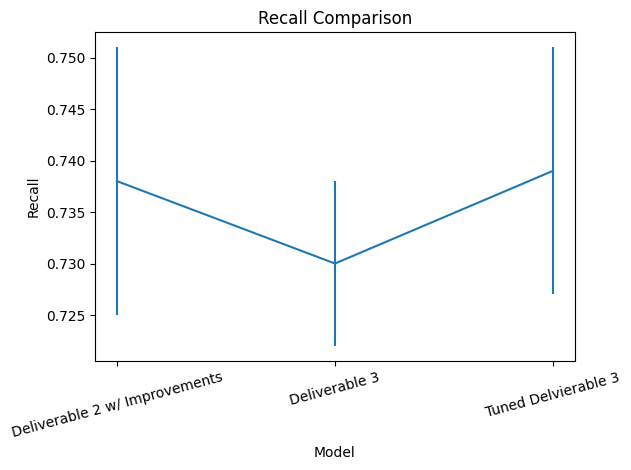

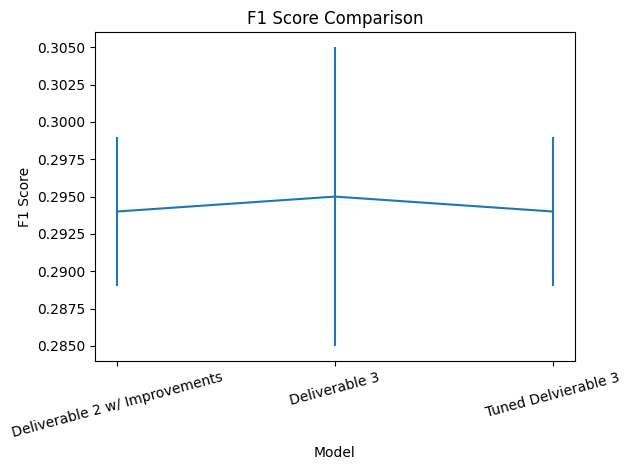

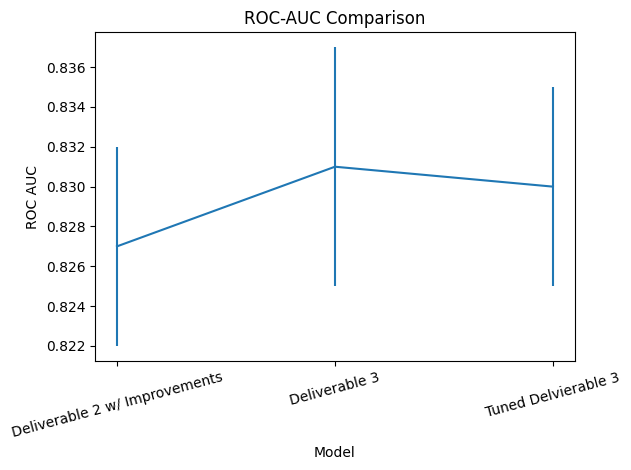

In [10]:
import matplotlib.pyplot as plt

models = ["Deliverable 2 w/ Improvements", "Deliverable 3", "Tuned Delvierable 3"]

recall_means = [0.738, 0.730, 0.739]
recall_stds  = [0.013, 0.008, 0.012]

f1_means = [0.294, 0.295, 0.294]
f1_stds  = [0.005, 0.010, 0.005]

roc_means = [0.827, 0.831, 0.830]
roc_stds  = [0.005, 0.006, 0.005]

#Recall
plt.figure()
plt.errorbar(models, recall_means, yerr=recall_stds)
plt.title("Recall Comparison")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#F1
plt.figure()
plt.errorbar(models, f1_means, yerr=f1_stds)
plt.title("F1 Score Comparison")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#ROCAUC
plt.figure()
plt.errorbar(models, roc_means, yerr=roc_stds)
plt.title("ROC-AUC Comparison")
plt.xlabel("Model")
plt.ylabel("ROC AUC")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### Analysis of Results

**Recall**: The tuned model slighlty improves recall compared to deliverable 2 and 3, which while small is still beneficial, as our main objective is to identify high-risk borrowers

**F1-Score**: The tuned model keeps a nearly identical F1-score to delvierable 2 and 3, meaning that the tuning only slightly changed the balance bet recall and percision

**ROC-AUC**: The tuned model improves on ROC AUC compared to deliverable 2 but is also nearly identical to deliverable 3, so the tuning of the hyperparameters simply maintained the improvements of the pipeline construction

## Section 3: Final Model Selection and Evaluation

We will pick a Logistic Regression model, along with the best-tuned hyperparameters as found in Section 2 via `GridSearchCV` as our final model. This is because:

- In Section 1, we attempted two different classifiers and one easily came out on top, Logistic Regression
    - Taking into account the performance as well, it runs very fast compared to a heavier model like Random Forest, and achieves greater results
- In Section 2, we analyzed the differences between our Logistic Regression baseline model in Deliverable 2, and another in 3 with the feedback integrated and model pipeline made, and finally with tuned hyperparameters
    - It is clear given the analysis and plots created that the `GridSearchCV`-tuned model performs better, as it has marginally better recall and F1 scores, and a small, but notable, increase in AUC
    - While F1 does perform slightly worse with the tuning compared to the baseline Deliverable 3 model, the trade-off with a better recall (which identifies the `True` labels well, which is what is important for this task) and AUC score; this trade-off should be worth it

Referring to the TA feedback provided from Deliverable 2, we will describe why we chose to use a 5-fold cross validation instead of 10-fold (for example). One main consideration was performance, as higher `k` values will lead to longer computational times, especially with a dataset that is as large as ours (over 100k samples). Looking back to Section 1, attempting to analyse different types of models would take much longer (double if we're using 10-folds, which will take a quite long time for Random Forests). Additionally, the bias-variance trade off is usually something to consider as well. If we increase the `k` value (meaning less samples used per cross-validation), we would have higher variance and lower bias than lower `k` values. In our case, it really didn't matter since we also tried performing 10-fold cross validation (this is shown later in this section) and achieved the exact same results as with 5-fold cross-validation. So the lower variance and higher bias didn't affect our model, and only caused longer training times.

Here is one final cross-validation run with this all in mind.

In [26]:
from sklearn.model_selection import cross_val_predict

print("\nFinal Logistic Regression Results:")

# To create residual plot later
y_pred = cross_val_predict(
    best_model,
    X.to_numpy(),
    y,
    cv=cv,
)

final_cv_results = cross_validate(
    best_model,
    X.to_numpy(),
    y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# To get the classes_ attribute in the next cell
log_pipeline.fit(X, y)

for metric in scoring.keys():
    mean = np.mean(final_cv_results[f'test_{metric}'])
    std = np.std(final_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")


Final Logistic Regression Results:
  recall  : 0.739 ± 0.012
  f1      : 0.294 ± 0.005
  roc_auc : 0.830 ± 0.005


### Cross-validation with 10 folds, to show no difference vs. 5 folds

In [27]:
print("\n10-fold Logistic Regression Results:")

tenf_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

tenf_cv_results = cross_validate(
    best_model,
    X.to_numpy(),
    y,
    cv=tenf_cv,
    scoring=scoring,
    return_train_score=False
)

for metric in scoring.keys():
    mean = np.mean(tenf_cv_results[f'test_{metric}'])
    std = np.std(tenf_cv_results[f'test_{metric}'])
    print(f"  {metric:8}: {mean:.3f} ± {std:.3f}")


10-fold Logistic Regression Results:
  recall  : 0.738 ± 0.017
  f1      : 0.294 ± 0.007
  roc_auc : 0.830 ± 0.007


As you can see, there is no change in performance (or, a very slight difference) when using 5 folds vs. 10 folds. Thus, we used 5 folds throughout to enhance performance.

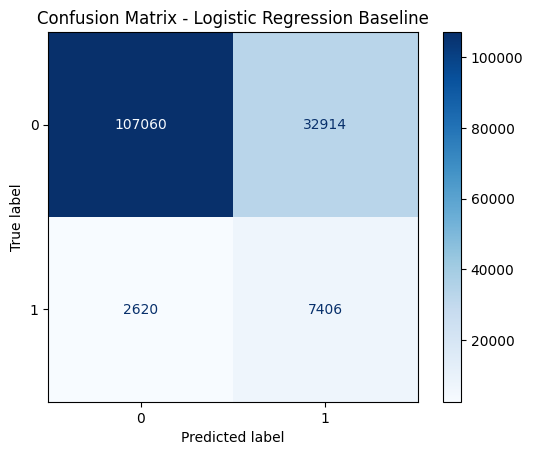

In [24]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay
)

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_pipeline.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.show()

### Analysis of error patterns and limitations

False-Positive Rate = 32914 / (32914 + 107060) = 0.235 = 23.5%

Unfortunately, despite this being our strongest model from the testing we have done throughout this project, the effects of a low F1-score remain and we see that there are many false-positives (23.5% of predictions are false-positive) with our predicted model. However, this is a much more preferable misclassification compared to a false-negative. If we had many false-negatives, that means we are failing to note if a particular client will be likely to default/be delinquent on their loan which is of major concern to the bank. A false-positive means that we will be flagging more individuals, but this allows for greater care taken to ensure that these clients don't have delinquent loans in the future (and could be seen as a form of risk-mitigation, as our classifier likely misclassifies these as they are a little too far from the separating hyperplane for the model's statistics). In a practical sense, these extra flags could be used to show a human-in-the-loop that they need to keep an eye on these individuals, or to provide their final judgement based on their personal analyses.

With all that being said, 23.5% is too often of a false-positive rate for our liking, and it would be nicer to decrease this significantly as this greatly impacts our model's validity.

We chose this plot to analyse as we knew that the F1 score is quite low, and we needed to see how significantly our predictions are affected by it. Clearly, it has a big impact. We did not choose to use a ROC curve as a confusion matrix is a bit more interpretable for this form of analysis (and can show other insights clearly and directly, like how many false-negatives we have). We did not choose a PDP curve for the same reason. A residual plot is not helpful at all in this situation since we are performing binary classification and not regression (residual plots are much more helpful in the latter, or in multi-class classification).

## Section 4: Integration of TA Feedback

| Area | TA Feedback | How We Addressed It |
|------|------------|------------------|
| **Baseline Model** | TA noted that our justification for using logistic regression as the baseline model was strong and that our metrics and interpretation were appropriate. | Highlighted logistic regression’s performance on recall, F1-score, and ROC AUC, showing it remained a strong baseline. This analysis clearly justified its use and provided context for comparing more complex models. |
| **Cross-Validation** | Cross-validation was implemented correctly, but the TA suggested adding more discussion about why we chose 5-fold CV instead of 10-fold. | Added a short explanation comparing 5-fold and 10-fold CV, discussing runtime, dataset size, and the variance-bias tradeoff. Explained why 5-fold CV is efficient and appropriate for our data. |
| **Diagnostics and Plots** | Our diagnostic plot and interpretation were insightful and well connected to model behavior. | Expanded Deliverable 3 by adding at least one diagnostic visualization for the final model and interpreted what it shows about strengths, weaknesses, and error patterns. |
| **Improvements** | TA noted that our improvements were well motivated and well explained. | Clearly explained why each hyperparameter was included in our tuning search space and compared tuned results to the Deliverable 2 baseline, showing how improvements built on earlier work. |
| **Discussion and Reflection** | Our summary of findings and trade-offs was clear, and our future steps were well thought out. | Provided a concise, evidence-based explanation for our final model choice, along with a clear summary of performance and limitations. |
| **Notebook Quality and Collaboration** | TA said our notebook was well organized and documented. | Maintained readable code cells, clear Markdown explanations, and a reproducible workflow using a scikit-learn Pipeline to ensure consistent quality in Deliverable 3. |



## Section 5: Final Reflection
Throughout this project, our team learned how to build a complete machine learning pipeline, starting from preprocessing and ending with model tuning and evaluation. Working with scikit-learn helped us understand how important structure and reproducibility are when building a full workflow. A major takeaway was realizing how much better a model can perform when hyperparameter tuning is done in a systematic way instead of by trial and error.

One of the most challenging parts was figuring out the right balance between model complexity and interpretability as we tried different models. Hyperparameter tuning also required careful choices around search spaces, runtime, and evaluation metrics. The most rewarding part was seeing the improvement between our Deliverable 2 baseline and our final tuned model, and being able to explain why those improvements happened.

If we had more time, we would explore additional feature engineering and more domain-specific analysis. Most of our work focused on modeling and tuning, so creating new features or testing transformations could help reveal more patterns in the data and possibly lead to even better performance.


## Section 6: Individual Contributions

| Name | Work Contributed                                                                        |
|---|-----------------------------------------------------------------------------------------|
| Emanuel Caravaggio | Systematic Hyperparameter Tuning                                                        |
| Patrick Favret | Full Pipeline Construction                                                              |
| Junoh Loy | Integration of TA Feedback, and Final Reflection                                        |
| Edward Tanurkov | Final Model Selection and Evaluation, time-analysis of Random Forest, Kaggle Submission |